In [2]:
"""
Data Engineer Take Home Project
=========

We’ve found that one of the best ways to evaluate engineering candidates is a take-home project. 
This project gives you a chance to work on some relevant code at home, and it gives us something concrete to 
discuss during your in-person interviews. Please choose the technologies that allow you to put your best foot forward. 
There are no bonus points given for finishing the project quickly.

# The Project

## Preface
For test delivery, the data set here is relatively small (data from [Denver's open data catalog]
(https://www.denvergov.org/opendata)).  You should approach this test as though the data were 1000x the actual 
size and frequently updated by real-time events.


#### Task 1 
Download data about [Denver 311 service requests]
(https://s3.amazonaws.com/ibotta-data-engineer-test/311_service_requests.csv.zip) 
([original source](http://data.denvergov.org/download/gis/311_service_requests/csv/311_service_requests.csv)) 
and [traffic accidents](https://s3.amazonaws.com/ibotta-data-engineer-test/traffic_accidents.csv.zip) 
([original source](http://data.denvergov.org/download/gis/traffic_accidents/csv/traffic_accidents.csv)). 
This data set, which is *not* perfect, contains events in the City and County of Denver for the previous 12 months. 
Even as the data grows at a high rate, it should be reasonably queryable for the tasks below.

#### Task 2
Write a process to transform the data into a queryable data store. The city updates these files periodically, 
with a rolling 1-year window. The process should be flexible enough to be able to ingest new data when it is available. 
Queries against the data store should perform well even with rapid data growth.

#### Task 3
Explore the data to find interesting patterns or trends and then write queries for the resulting reports. 
The types of questions you might ask include the following:

- Are there seasonal trends to the different types of events?
- Which types of events are more common by geographic areas, as defined by coordinates or neighborhood?
- How long are typical response/resolution times? Do these differ by type of event, geography, or other factors?
- What correlations are there between the two data sets?

Treat your code as if it will be used in production to deliver insights to users. Think about readability 
and maintainability, and consider automated testing of code wherever possible.

# Deliverable
Please provide the code for the assignment either in a private repository (GitHub or Bitbucket) or as a zip file.
"""

Out[1]: "\nData Engineer Take Home Project\n=========\n\nWe’ve found that one of the best ways to evaluate engineering candidates is a take-home project. \nThis project gives you a chance to work on some relevant code at home, and it gives us something concrete to \ndiscuss during your in-person interviews. Please choose the technologies that allow you to put your best foot forward. \nThere are no bonus points given for finishing the project quickly.\n\n# The Project\n\n## Preface\nFor test delivery, the data set here is relatively small (data from [Denver's open data catalog]\n(https://www.denvergov.org/opendata)). You should approach this test as though the data were 1000x the actual \nsize and frequently updated by real-time events.\n\n\n#### Task 1 \nDownload data about [Denver 311 service requests]\n(https://s3.amazonaws.com/ibotta-data-engineer-test/311_service_requests.csv.zip) \n([original source](http://data.denvergov.org/download/gis/311_service_requests/csv/311_service_requests.csv)) \nand [traffic accidents](https://s3.amazonaws.com/ibotta-data-engineer-test/traffic_accidents.csv.zip) \n([original source](http://data.denvergov.org/download/gis/traffic_accidents/csv/traffic_accidents.csv)). \nThis data set, which is *not* perfect, contains events in the City and County of Denver for the previous 12 months. \nEven as the data grows at a high rate, it should be reasonably queryable for the tasks below.\n\n#### Task 2\nWrite a process to transform the data into a queryable data store. The city updates these files periodically, \nwith a rolling 1-year window. The process should be flexible enough to be able to ingest new data when it is available. \nQueries against the data store should perform well even with rapid data growth.\n\n#### Task 3\nExplore the data to find interesting patterns or trends and then write queries for the resulting reports. \nThe types of questions you might ask include the following:\n\n- Are there seasonal trends to the different types of events?\n- Which types of events are more common by geographic areas, as defined by coordinates or neighborhood?\n- How long are typical response/resolution times? Do these differ by type of event, geography, or other factors?\n- What correlations are there between the two data sets?\n\nTreat your code as if it will be used in production to deliver insights to users. Think about readability \nand maintainability, and consider automated testing of code wherever possible.\n\n# Deliverable\nPlease provide the code for the assignment either in a private repository (GitHub or Bitbucket) or as a zip file.\n"

In [4]:
# Import all required libraries and frameworks
# Basic processing libraries
import urllib 
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
from datetime import datetime

# Visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt

# Machine learning packages
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import keras
import tensorflow as tf
from keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Parition datasets based on amount of slots available on clusters
# Minimized amount of executors for cheap development for this project
partitions = sc.defaultParallelism
print("Number of Partitions: 2 cores x 2 workers =", partitions, "slots")

Number of Partitions: 2 cores x 2 workers = 4 slots

## 1. Extract

In [9]:
# Retrieve zip files directly from s3 bucket
urllib.request.urlretrieve("https://s3.amazonaws.com/ibotta-data-engineer-test/311_service_requests.csv.zip", "/tmp/311_service_requests.csv.zip")
urllib.request.urlretrieve("https://s3.amazonaws.com/ibotta-data-engineer-test/traffic_accidents.csv.zip", "/tmp/traffic_accidents.csv.zip")

Out[3]: ('/tmp/traffic_accidents.csv.zip', <http.client.HTTPMessage at 0x7f6ed3789250>)

In [10]:
# Utilize shell code to unzip, remove first comment line, and remove unzipped files

In [11]:
%sh
unzip /tmp/311_service_requests.csv.zip
tail -n +2 311_service_requests.csv > service_temp.csv
rm 311_service_requests.csv

Archive: /tmp/311_service_requests.csv.zip
 inflating: 311_service_requests.csv 
 creating: __MACOSX/
 inflating: __MACOSX/._311_service_requests.csv

In [12]:
%sh
unzip /tmp/traffic_accidents.csv.zip
tail -n +2 traffic_accidents.csv > traffic_temp.csv
rm traffic_accidents.csv

Archive: /tmp/traffic_accidents.csv.zip
 inflating: traffic_accidents.csv 
 inflating: __MACOSX/._traffic_accidents.csv

In [13]:
# Move temp files to DBFS
dbutils.fs.mv("file:/databricks/driver/service_temp.csv", "dbfs:/tmp/311_service_requests.csv")
dbutils.fs.mv("file:/databricks/driver/traffic_temp.csv", "dbfs:/tmp/traffic_accidents.csv") 

Out[6]: True

In [14]:
# Build 311 Service Requests Spark Dataframe
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)    # Enable better visual for viewing Spark dataframes

# Declare schema to avoid expensive processing costs of inferring schema
service_schema = StructType(
  [
    StructField("CASE_SUMMARY", StringType(), False), StructField("CASE_STATUS", StringType(), False),
    StructField("CASE_SOURCE", StringType(), False), StructField("CASE_CREATED_DATE", StringType(), False),
    StructField("CASE_CREATED_DTTM", StringType(), False), StructField("CASE_CLOSED_DATE", StringType(), False),
    StructField("CASE_CLOSED_DTTM", StringType(), False), StructField("FIRST_CALL_RESOLUTION", StringType(), False), 
    StructField("CUSTOMER_ZIP_CODE", StringType(), False), StructField("INCIDENT_ADDRESS_1", StringType(), False), 
    StructField("INCIDENT_ADDRESS_2", StringType(), False), StructField("INCIDENT_INTERSECTION_1", StringType(), False), 
    StructField("INCIDENT_INTERSECTION_2", StringType(), False), StructField("INCIDENT_ZIP_CODE", StringType(), False), 
    StructField("LONGITUDE", StringType(), False), StructField("LATITUDE", StringType(), False), 
    StructField("AGENCY", StringType(), False), StructField("DIVISION", StringType(), False), 
    StructField("MAJOR_AREA", StringType(), False), StructField("TYPE", StringType(), False), 
    StructField("TOPIC", StringType(), False), StructField("COUNCIL_DISTRICT", IntegerType(), False), 
    StructField("POLICE_DISTRICT", IntegerType(), False), StructField("NEIGHBORHOOD", StringType(), False)
  ]
)

# Build Spark dataframe with custom parameters
service_sdf = spark.read.format("csv") \
                        .schema(service_schema) \
                        .option("header","true") \
                        .option('numPartitions', partitions) \
                        .load("dbfs:/tmp/311_service_requests.csv")

# Inspect shape of dataframe
print("Shape of Service Request Data:", \
      "Rows -", '{:,}'.format(service_sdf.count()), \
      ", Columns -", len(service_sdf.columns))

Shape of Service Request Data: Rows - 470,640 , Columns - 24

In [15]:
# Build Traffic Accidents Spark Dataframe
# Declare schema to avoid expensive processing costs of inferring schema
traffic_schema = StructType(
  [
    StructField("INCIDENT_ID", StringType(), False), StructField("OFFENSE_ID", LongType(), False),
    StructField("OFFENSE_CODE", IntegerType(), False), StructField("OFFENSE_CODE_EXTENSION", StringType(), False), 
    StructField("OFFENSE_TYPE_ID", StringType(), False), StructField("OFFENSE_CATEGORY_ID", StringType(), False), 
    StructField("FIRST_OCCURRENCE_DATE", TimestampType(), False), StructField("LAST_OCCURRENCE_DATE", StringType(), False), 
    StructField("REPORTED_DATE", TimestampType(), False), StructField("INCIDENT_ADDRESS", StringType(), False), 
    StructField("GEO_X", StringType(), False), StructField("GEO_Y", StringType(), False), 
    StructField("GEO_LON", StringType(), False), StructField("GEO_LAT", StringType(), False), 
    StructField("DISTRICT_ID", IntegerType(), False), StructField("PRECINCT_ID", IntegerType(), False), 
    StructField("NEIGHBORHOOD_ID", StringType(), False), StructField("BICYCLE_IND", ByteType(), False), 
    StructField("PEDESTRIAN_IND", ByteType(), False)
  ]
)

# Build Spark dataframe with custom parameters
traffic_sdf = spark.read.format("csv") \
                        .schema(traffic_schema) \
                        .option("header","true") \
                        .option('numPartitions', partitions) \
                        .option('partitionColumn', 'OFFENSE_ID') \    # Partition dataframe on unique index column for more efficiency
                        .load("dbfs:/tmp/traffic_accidents.csv")

# Inspect shape of dataframe
print("Shape of Service Request Data:", \
      "Columns -", '{:,}'.format(traffic_sdf.count()), \
      ", Rows -", len(traffic_sdf.columns))

Shape of Service Request Data: Columns - 123,663 , Rows - 19

## 2. Transform

In [19]:
# Transform 311 Service Request Dataframe
# Drop outlier date interfering with processing
service_sdf = service_sdf.filter(col('CASE_CREATED_DATE') != '01/29/2016 09:36:08 PM')

# Change date columns to date types
service_sdf = service_sdf.withColumn('CASE_CREATED_DATE', to_date(unix_timestamp('CASE_CREATED_DATE', 'MM/dd/yyy').cast('timestamp'))) \
                         .withColumn('CASE_CLOSED_DATE', to_date(unix_timestamp('CASE_CLOSED_DATE', 'MM/dd/yyy').cast('timestamp')))

# Feature engineer for new columns
service_sdf = service_sdf.withColumn('CASE_CREATED_MONTH_DATE', trunc('CASE_CREATED_DATE', "month")) \
                         .withColumn('CASE_CLOSED_MONTH_DATE', trunc('CASE_CLOSED_DATE', "month")) \
                         .withColumn('RESOLUTION_DURATION', datediff(col('CASE_CLOSED_DATE'), col('CASE_CREATED_DATE'))) \
                         .cache()    # Cache data for quicker analytics, avoid lazy evaluation

# Inspect shape of dataframe
print("Shape of Service Request Data:", \
      "Rows -", '{:,}'.format(service_sdf.count()), \
      ", Columns -", len(service_sdf.columns))

Shape of Service Request Data: Rows - 470,639 , Columns - 27

In [20]:
# Transform 311 Service Request Dataframe
# Change date columns to date types
traffic_sdf = traffic_sdf.withColumn('FIRST_OCCURRENCE_DATE', to_date(unix_timestamp('FIRST_OCCURRENCE_DATE', 'yyyy-MM-dd 00:00:00').cast('timestamp'))) \
                         .withColumn('LAST_OCCURRENCE_DATE', to_date(unix_timestamp('LAST_OCCURRENCE_DATE', 'yyyy-MM-dd 00:00:00').cast('timestamp'))) \
                         .withColumn('REPORTED_DATE', to_date(unix_timestamp('REPORTED_DATE', 'yyyy-MM-dd 00:00:00').cast('timestamp')))

# Feature engineer for new columns
traffic_sdf = traffic_sdf.withColumn('REPORTED_MONTH_DATE', trunc('REPORTED_DATE', "month")) \
                         .cache()    # Cache data for quicker analytics, avoid lazy evaluation

# Inspect shape of dataframe
print("Shape of Service Request Data:", \
      "Rows -", '{:,}'.format(traffic_sdf.count()), \
      ", Columns -", len(traffic_sdf.columns))

Shape of Service Request Data: Rows - 123,663 , Columns - 20

In [21]:
# Create SQL temp views
# I decided to convert Spark Dataframes to SQL for analytics section, 
#    because SQL is a much more common querying language amongst analysts
service_sdf.createOrReplaceTempView("SERVICE_REQUESTS")
traffic_sdf.createOrReplaceTempView("TRAFFIC_ACCIDENTS")

## 3. Analytics

#### A. Easy querying techniques from temp SQL views

In [25]:
%sql
-- Databricks allows code in 4 languages, including these SQL magic commands
-- Quick query for glance into data view
SELECT * FROM SERVICE_REQUESTS LIMIT 10

CASE_SUMMARY,CASE_STATUS,CASE_SOURCE,CASE_CREATED_DATE,CASE_CREATED_DTTM,CASE_CLOSED_DATE,CASE_CLOSED_DTTM,FIRST_CALL_RESOLUTION,CUSTOMER_ZIP_CODE,INCIDENT_ADDRESS_1,INCIDENT_ADDRESS_2,INCIDENT_INTERSECTION_1,INCIDENT_INTERSECTION_2,INCIDENT_ZIP_CODE,LONGITUDE,LATITUDE,AGENCY,DIVISION,MAJOR_AREA,TYPE,TOPIC,COUNCIL_DISTRICT,POLICE_DISTRICT,NEIGHBORHOOD,CASE_CREATED_MONTH_DATE,CASE_CLOSED_MONTH_DATE,RESOLUTION_DURATION
Trash,Closed - No Response from Customer,Phone,2015-12-31,12/31/2015 06:51:06 PM,2015-12-31,12/31/2015 06:52:54 PM,N,null,4447 N Duluth Way,null,null,null,80239,-104.82271481363699,39.77693112657128,Public Works,null,null,Request,null,null,null,null,2015-12-01,2015-12-01,0
Trash cart,Closed - Service Completed,Phone,2015-12-31,12/31/2015 04:50:53 PM,2016-01-06,01/06/2016 09:33:14 PM,N,null,19542 E 54th Ave,null,null,null,80249,-104.75767644491130,39.7930957280864850,Public Works,null,null,Request,null,null,null,null,2015-12-01,2016-01-01,6
Missed Recycle,Closed - Service Completed,Phone,2015-12-31,12/31/2015 09:01:14 PM,2016-01-05,01/05/2016 04:04:10 PM,N,null,2633 N Marion St,null,null,null,80205,-104.97214618100071,39.7552209779668640,Public Works,null,null,Request,null,null,null,null,2015-12-01,2016-01-01,5
recycle cart,In-Progress,Phone,2015-12-31,12/31/2015 11:26:39 PM,null,null,null,null,1560 N Steele St,null,null,null,80206,-104.94999546621705,39.74136060950561,Public Works,null,null,Request,null,null,null,null,2015-12-01,null,null
Missed Trash,Closed - Service Completed,Phone,2015-12-31,12/31/2015 08:36:47 PM,2016-01-07,01/07/2016 07:18:53 PM,N,null,300 N Julian St,null,null,null,80219,-105.03122524434883,39.7215211218033840,Public Works,null,null,Request,null,null,null,null,2015-12-01,2016-01-01,7
missed trash,Closed - Service Completed,Phone,2015-12-31,12/31/2015 12:01:18 AM,2016-01-07,01/07/2016 05:44:24 PM,N,null,3735 N Inca St,null,null,null,80211,-104.99821654145950,39.76871071063187,Public Works,null,null,Request,null,null,null,null,2015-12-01,2016-01-01,7
Light in Stapleton,Customer Updated,Email - 311,2015-12-31,12/31/2015 08:59:16 PM,null,null,N,80238-3342,null,null,Florence Way,Havana St,null,-104.98469944299967,39.73914743400046,Public Works,null,null,Request,null,null,null,null,2015-12-01,null,null
No Parking Sign Problem,In-Progress,Phone,2015-12-31,12/31/2015 04:56:03 PM,null,null,null,null,3861 N Raleigh St,null,null,null,80212,-105.04171609322242,39.77053008859384,Public Works,null,null,Request,null,null,null,null,2015-12-01,null,null
Recycling,Closed - Service Completed,Phone,2015-12-31,12/31/2015 09:40:05 PM,2016-01-07,01/07/2016 07:19:44 PM,N,null,5575 N Jebel Ct,null,null,null,80249,-104.75136631760074,39.79702120136846,Public Works,null,null,Request,null,null,null,null,2015-12-01,2016-01-01,7
WasteWise 2016,Closed - Answer Provided,Phone,2015-12-31,12/31/2015 08:31:41 PM,2015-12-31,12/31/2015 08:34:26 PM,N,null,5 Polo Field Ln,null,null,null,80209,-104.95564008172369,39.70873769419034,Public Works,null,null,Request,null,null,null,null,2015-12-01,2015-12-01,0


In [26]:
%sql
-- Quick query for glance into data view
SELECT * FROM TRAFFIC_ACCIDENTS LIMIT 10

INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,BICYCLE_IND,PEDESTRIAN_IND,REPORTED_MONTH_DATE
2013227315.0,2013227315544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,1900 E BUCHTEL BLVD,3150708.0,1674532.0,-104.9645194,39.68417,3,313,university,null,null,2013-05-01
2013227351.0,2013227351544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,null,3167776.0,1692387.0,-104.9034602,39.7328937,2,223,montclair,null,null,2013-05-01
2013227410.0,2013227410540100,5401,0,traffic-accident-hit-and-run,traffic-accident,2013-05-21,null,2013-06-07,S LOWELL BLVD / W GREENWOOD PL,3130885.0,1664949.0,-105.0351254,39.6581619,4,423,harvey-park-south,null,null,2013-06-01
2013227430.0,2013227430544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,I25 HWYNB / 20TH ST,3139350.0,1702436.0,-105.0043337,39.7609489,1,113,highland,null,null,2013-05-01
2013227451.0,2013227451544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,null,3148211.0,1672456.0,-104.973434,39.678511,3,313,rosedale,null,null,2013-05-01
2013227483.0,2013227483544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,I25 HWYSB / W 48TH AVE,3143456.0,1710878.0,-104.9895603,39.7840611,1,112,globeville,null,null,2013-05-01
2013227524.0,2013227524544100,5441,0,traffic-accident,traffic-accident,2013-05-21,null,2013-05-21,1000 BLOCK N SPEER BLVD,3142870.0,1692070.0,-104.9920196,39.7324391,6,611,civic-center,null,null,2013-05-01
2013278866.0,2013278866544100,5441,0,traffic-accident,traffic-accident,2013-06-20,null,2013-06-20,null,3146913.0,1693705.0,-104.9776114,39.7368645,6,623,capitol-hill,1,null,2013-06-01
2013278918.0,2013278918540100,5401,0,traffic-accident-hit-and-run,traffic-accident,2013-06-20,null,2013-06-20,N JOSEPHINE ST / E 6TH AVE,3152388.0,1689639.0,-104.9582302,39.7256146,2,312,cherry-creek,null,null,2013-06-01
2013279038.0,2013279038544100,5441,0,traffic-accident,traffic-accident,2013-06-20,null,2013-06-20,E 8TH AVE / N BROADWAY ST,3144175.0,1690859.0,-104.987404,39.7290945,6,611,capitol-hill,null,null,2013-06-01


#### B. Are there seasonal trends to the different types of events?

In [28]:
%sql
-- Databricks is used to easily create visualizations on the fly. Each SQL query has a visualization to expose insights.
-- View Case Status type counts by month
-- Results: Seems to be some irregularities in the 2 beginning months and last month. In between months display consistent trends across all Case Statuses.

SELECT CASE_STATUS, CASE_CREATED_MONTH_DATE, COUNT(CASE_STATUS) AS CNT
FROM SERVICE_REQUESTS
GROUP BY 1, 2
ORDER BY 2

CASE_STATUS,CASE_CREATED_MONTH_DATE,CNT
Re-Routed,2015-10-01,2
Closed - Transfered to External Agency,2015-10-01,28
Re-Opened,2015-10-01,1
Routed to Agency,2015-10-01,179
Closed - Other,2015-10-01,23858
Closed - Created in Error,2015-10-01,1
On Hold (Internal),2015-10-01,1
In-Progress,2015-10-01,201
Closed - Service Completed,2015-10-01,6
Closed - Answer Provided,2015-10-01,339


In [29]:
%sql
-- View Case Source type counts by month
-- Results: Seems to be some irregularities in the first and last month. In between months display consistent trends across all variables,
--     with phone channel the primary method of requesting services.

SELECT CASE_SOURCE, CASE_CREATED_MONTH_DATE, COUNT(CASE_SOURCE) AS CNT
FROM SERVICE_REQUESTS
GROUP BY 1, 2
ORDER BY 2

CASE_SOURCE,CASE_CREATED_MONTH_DATE,CNT
Other,2015-10-01,79
Phone,2015-10-01,22589
USPS Mail,2015-10-01,2
Fax,2015-10-01,5
Email,2015-10-01,755
Walk-In,2015-10-01,6
PocketGov,2015-10-01,1180
Fax,2015-11-01,2
USPS Mail,2015-11-01,1
PocketGov,2015-11-01,1592


In [30]:
%sql
-- Type of requests by month.
-- Results: Inquiries and requests consume the majority of the share month to month.

SELECT TYPE, CASE_CREATED_MONTH_DATE, COUNT(TYPE) AS CNT
FROM SERVICE_REQUESTS
GROUP BY 1, 2
ORDER BY 2

TYPE,CASE_CREATED_MONTH_DATE,CNT
Request,2015-10-01,2766
Compliment,2015-10-01,17
Complaint,2015-10-01,5604
Inquiry,2015-10-01,16229
Inqury,2015-11-01,17
Inquiry,2015-11-01,22340
Request,2015-11-01,5723
Compliment,2015-11-01,14
Complaint,2015-11-01,5688
null,2015-11-01,0


In [31]:
%sql
-- View traffic accidents over entire interval
-- There doesn't seem to be any obvious trends for total accidents.

SELECT OFFENSE_CATEGORY_ID, REPORTED_MONTH_DATE, COUNT(*) AS CNT
FROM TRAFFIC_ACCIDENTS
GROUP BY 1, 2
ORDER BY 2

OFFENSE_CATEGORY_ID,REPORTED_MONTH_DATE,CNT
all-other-crimes,2011-01-01,1
murder,2011-01-01,1
traffic-accident,2011-01-01,1770
traffic-accident,2011-02-01,1755
all-other-crimes,2011-02-01,1
traffic-accident,2011-03-01,1591
all-other-crimes,2011-03-01,1
all-other-crimes,2011-04-01,3
traffic-accident,2011-04-01,1621
murder,2011-05-01,1


In [32]:
%sql
-- View accidents by district, per month.
-- The top 4 districts seem to follow a similar trend over each month.

SELECT DISTRICT_ID, REPORTED_MONTH_DATE, COUNT(*) AS CNT
FROM TRAFFIC_ACCIDENTS
GROUP BY 1, 2
ORDER BY 2

DISTRICT_ID,REPORTED_MONTH_DATE,CNT
1,2011-01-01,303
4,2011-01-01,205
3,2011-01-01,570
7,2011-01-01,11
6,2011-01-01,299
5,2011-01-01,161
2,2011-01-01,223
1,2011-02-01,360
7,2011-02-01,16
5,2011-02-01,134


In [33]:
%sql
-- View Top 10 precincts dealing with accidents
-- Results: These precincts seem to all follow the same trend month-over-month.

SELECT PRECINCT_ID, REPORTED_MONTH_DATE, COUNT(*) AS CNT
FROM TRAFFIC_ACCIDENTS
WHERE PRECINCT_ID IN (

  -- Get Top 10 precincts by traffic accidents
      SELECT PRECINCT_ID
      FROM (
          SELECT PRECINCT_ID, COUNT(*) AS CNT
          FROM TRAFFIC_ACCIDENTS
          GROUP BY 1
          ORDER BY 2 DESC
          LIMIT 10
      ) AS A
    )
GROUP BY 1, 2
ORDER BY 2


PRECINCT_ID,REPORTED_MONTH_DATE,CNT
623,2011-01-01,79
312,2011-01-01,99
311,2011-01-01,148
322,2011-01-01,72
313,2011-01-01,96
611,2011-01-01,93
511,2011-01-01,103
113,2011-01-01,58
323,2011-01-01,94
123,2011-01-01,75


#### 3. Which types of events are more common by geographic areas, as defined by coordinates or neighborhood?

In [36]:
%sql
-- Top 10 traffic accident neighborhoods 
SELECT NEIGHBORHOOD_ID, COUNT(*) AS NEIGHBORHOOD_CNT 
FROM TRAFFIC_ACCIDENTS 
GROUP BY 1 
ORDER BY 2 DESC 
LIMIT 10

NEIGHBORHOOD_ID,NEIGHBORHOOD_CNT
stapleton,6697
baker,6316
capitol-hill,4030
five-points,3862
hampden-south,3855
lincoln-park,3760
montbello,3047
highland,2920
globeville,2905
cbd,2648


In [37]:
%sql
-- Top 10 accident neighborhoods by month
-- Results: Neighborhoods trend similar patterns  over the months.
SELECT NEIGHBORHOOD_ID, REPORTED_MONTH_DATE, COUNT(*) AS NEIGHBORHOOD_CNT 
FROM TRAFFIC_ACCIDENTS
WHERE NEIGHBORHOOD_ID IN (

  -- Get Top 10 traffic accidents neighborhoods
      SELECT NEIGHBORHOOD_ID
      FROM (
          SELECT NEIGHBORHOOD_ID, COUNT(*) AS CNT
          FROM TRAFFIC_ACCIDENTS
          GROUP BY 1
          ORDER BY 2 DESC
          LIMIT 10
      ) AS A
    )
GROUP BY 1, 2 
ORDER BY 2

NEIGHBORHOOD_ID,REPORTED_MONTH_DATE,NEIGHBORHOOD_CNT
highland,2011-01-01,37
montbello,2011-01-01,39
globeville,2011-01-01,51
hampden-south,2011-01-01,55
lincoln-park,2011-01-01,46
stapleton,2011-01-01,94
baker,2011-01-01,83
five-points,2011-01-01,49
cbd,2011-01-01,55
capitol-hill,2011-01-01,80


In [38]:
# Databricks doesn't do well with maps with zip code, or lat/long data. Would prefer Tableau to plot this data.

#### 4. How long are typical response/resolution times? Do these differ by type of event, geography, or other factors?

In [41]:
%sql
-- Top 10 highest zip code counts, and their average resolution in days
-- Results: The largest zip code with the longest durations is 80239 with over 3 days average duration.
--     80207 shares the lowest average resolution duration with 80212, around 2 days.

SELECT INCIDENT_ZIP_CODE, COUNT(INCIDENT_ZIP_CODE) AS ZIP_CNT
  , AVG(RESOLUTION_DURATION) AS AVG_RES_DURATION
FROM SERVICE_REQUESTS
GROUP BY 1
HAVING AVG(RESOLUTION_DURATION) IS NOT NULL
ORDER BY 2 DESC
LIMIT 10

INCIDENT_ZIP_CODE,ZIP_CNT,AVG_RES_DURATION
80219,11154,2.5210795273075695
80204,7579,2.765791632485644
80211,7372,2.294863242161441
80205,7306,2.790029864461291
80210,6660,2.9680270340525086
80220,6154,2.615572436245252
80239,5020,3.2011732229123533
80223,4616,2.560840707964602
80212,4514,1.92449773169151
80207,4502,1.8873192061890347


In [42]:
%sql
-- Average resolution durations for all modes of case sources.
-- Results: Emailing the mayor's office will result in the longest durations, around 2 weeks.
-- Facebook inquires, walk-ins, and phones result in some of the shortest durations, under 1 day.

SELECT CASE_SOURCE, COUNT(CASE_SOURCE) AS CASE_SOURCE_CNT
  , AVG(RESOLUTION_DURATION) AS AVG_RES_DURATION
FROM SERVICE_REQUESTS
GROUP BY 1
HAVING AVG(RESOLUTION_DURATION) IS NOT NULL
ORDER BY 2 DESC

CASE_SOURCE,CASE_SOURCE_CNT,AVG_RES_DURATION
Phone,422989,0.7558202678807885
PocketGov,33026,3.04058921315109
Email - 311,6597,1.8945185719437432
Email - Mayor's Office,3524,13.75
Email - City Clerk,2255,0.6655372700871249
Email,1437,1.5192307692307692
Walk-In,488,0.4820627802690583
Other,117,5.412844036697248
Email - Assessor,57,0.43859649122807015
City Council District 4,25,2.0


#### 5. What correlations are there between the two data sets?

In [45]:
# Transform all pertinent categorical variables into orginal numbers, so correlations can be computed.
ord_encoder = ce.OrdinalEncoder()
service_string_pdf = service_sdf.select('CASE_STATUS', 'CASE_SOURCE', 'FIRST_CALL_RESOLUTION', 'CUSTOMER_ZIP_CODE', \
                                     'AGENCY', 'TYPE', 'COUNCIL_DISTRICT', 'POLICE_DISTRICT', 'RESOLUTION_DURATION') \
                             .toPandas()
service_encoder_pdf = ord_encoder.fit_transform(service_string_pdf)

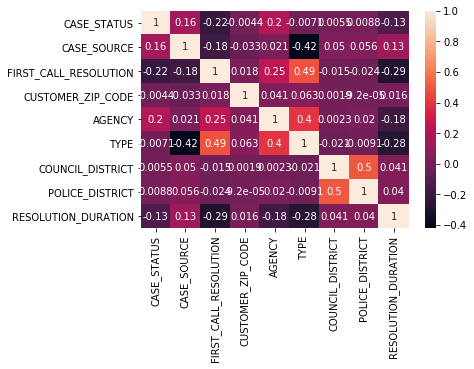

In [46]:
# Correlation heatmap matrix between columns
# Results: Highly correlated columns
#     a. 'FIRST_CALL_RESOLUTION' & 'TYPE' = .49
#     b. 'POLICE_DISTRICT' & 'COUNCIL_DISTRICT' = .50, police districts may belong to council districts
#     c. 'CASE_SOURCE' & 'TYPE' = -.42

corr_matrix = service_encoder_pdf.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

In [47]:
# Transform all pertinent categorical variables into orginal numbers, so correlations can be computed.
ord_encoder = ce.OrdinalEncoder()
traffic_string_pdf = traffic_sdf.select('OFFENSE_CODE', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'DISTRICT_ID', \
                                     'PRECINCT_ID', 'NEIGHBORHOOD_ID', 'BICYCLE_IND', 'PEDESTRIAN_IND') \
                             .toPandas()
traffic_encoder_pdf = ord_encoder.fit_transform(traffic_string_pdf)

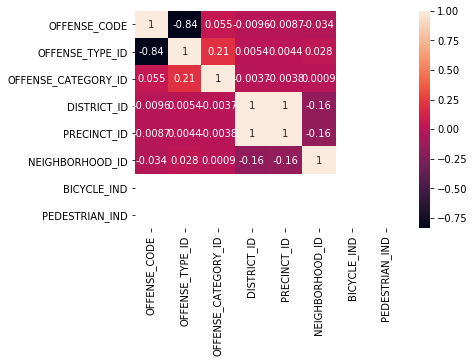

In [48]:
# Correlation heatmap matrix between columns
# Results: Highly correlated columns
#     a. 'FIRST_CALL_RESOLUTION' & 'TYPE' = -.84, office_type_id is a subset of offense_code
#     b. 'POLICE_DISTRICT' & 'COUNCIL_DISTRICT' = 1, police districts are directly aligned with precincts

corr_matrix = traffic_encoder_pdf.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

## 4. Machine Learning Prediction Model

In [52]:
""" Developed deep learning model to see if traffic accidents can be predicted in particular neighborhoods"""

In [53]:
# Build aggregated counts of accidents for each day in specific neighborhoods.
traffic_rnn_pdf = traffic_sdf.filter(col('NEIGHBORHOOD_ID') == 'stapleton') \
                             .filter(col('REPORTED_DATE') >= '2015-01-01') \
                             .select('REPORTED_DATE') \
                             .groupby('REPORTED_DATE') \
                             .count() \
                             .orderBy('REPORTED_DATE') \
                             .toPandas()

In [54]:
# Tranform dataframe to array, and scale the data
traffic_rnn_pdf = traffic_rnn_pdf.set_index('REPORTED_DATE')
train = traffic_rnn_pdf
train_array = train.to_numpy()
scaler = MinMaxScaler()
dataset = scaler.fit_transform(train_array)

In [55]:
# Function to prepare (x, y) data points for time series
def create_dataset(values, look_back=1):
  _x, _y = [], []
  for i in range(len(values)-look_back-1):
      a = values[i:(i+look_back)]      # stack a list of values
      _x.append(a)                        # set x
      _y.append(values[i + look_back]) # set y
  return np.array(_x), np.array(_y)

In [56]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)   # make 80% data train
train = dataset[:train_size] # set the train data
test  = dataset[train_size:] # set the test data 

# reshape into X=t and Y=t+1
look_back = 1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

In [57]:
# Calculate cost metrics
def metrics_time_series(y_true, y_pred):
  mae = np.round(mean_absolute_error(y_true, y_pred), 2)
  mse = np.round(mean_squared_error(y_true, y_pred), 2)
  print(f"The mean absolute error is: {mae}")
  print(f"The mean squared error is: {mse}")
  return mae, mse

In [58]:
# Primary multi-scenario deep learning algorithm

def time_series_deep_learning(x_train, y_train, x_test, y_test, model_dl,  unit, look_back, cnn=False, bidirection=False, stacked=False):
  
    # Configure an earlystopping callbacks to avoid overfitting
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    # instance of a Sequential model
    model = Sequential()
    
    if cnn: # test if cnn part is needed 
        print("CNN")
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Dropout(0.2))
    
    if not bidirection and not stacked: # test if simple model is needed
        print("Simple Model")
        name = model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not bidirection: # test if bidirectional  model is needed
        print("Stacked Model")
        name = "Stacked_"+model_dl.__name__
        model.add(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True))
        model.add(model_dl(unit,  input_shape=(look_back, 1)))
    elif not stacked: # test if stacked models are needed
        print("Bidirectional Model")
        name = "Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
    else: # test if bidirectional and stacked models are needed
        print("Stacked Bidirectional Model")
        name = "Stacked_Bi_"+model_dl.__name__
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1), return_sequences=True)))
        model.add(Bidirectional(model_dl(unit,  input_shape=(look_back, 1))))
        
    if cnn: # update name with cnn part 
        name = "CNN_"+name
    
    # add Dense layer with one layer and activation function linear to predict continuous values 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # MSE loss but can be replace by 'mean_absolute_error'
    model.fit(x_train, y_train, epochs=1, batch_size=10, callbacks=[es], verbose=2)
    
    # make predictions
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    train_y = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    test_y = scaler.inverse_transform(y_test)
    
    # compute the metrics 
    print("Train")
    mae_train, mse_train = metrics_time_series( train_y, train_predict)
    print("Test")
    mae_test, mse_test = metrics_time_series( test_y, test_predict)
    
    return train_predict, train_y, test_predict, test_y, pd.DataFrame([name, mae_train, mse_train, mae_test, mse_test], index=["Name", "mae_train", "mse_train", "mae_test", "mse_test"]).T

In [59]:
def plotting_predictions(dataset, look_back, train_predict,  test_predict):
  
# shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict
    
# plot baseline and predictions
    plt.figure(figsize=(20,10))
    plt.plot(scaler.inverse_transform(dataset[200:]), 'b+--', label="Data")
    plt.plot(trainPredictPlot[200:], 'g+-', label='Train')
    plt.plot(testPredictPlot[200:], 'r.--', label="Test")
    plt.legend()
    plt.grid(True)
    plt.show()

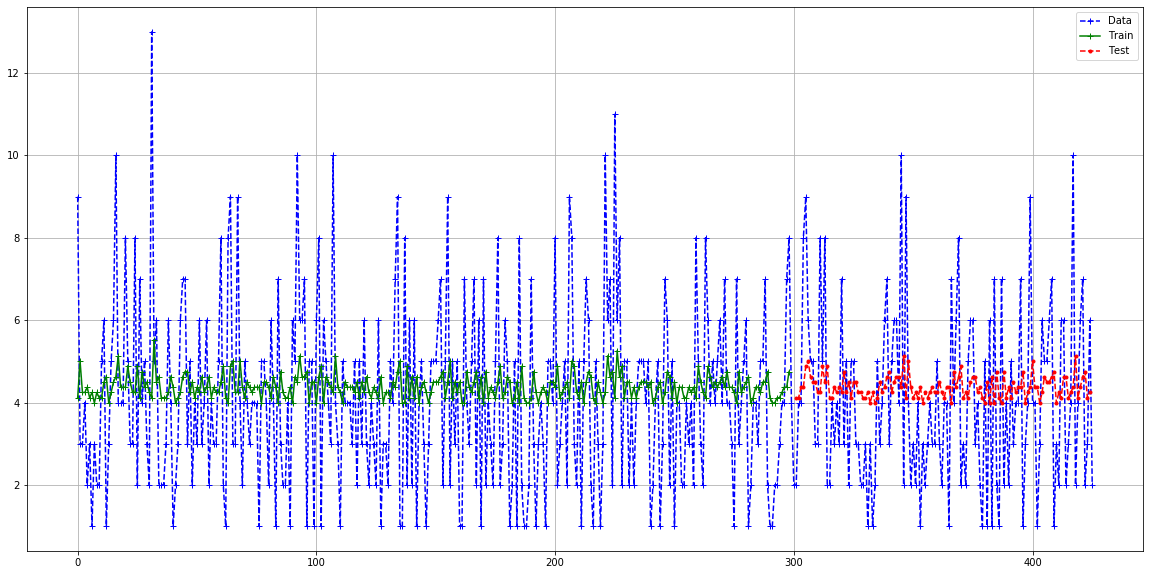

In [60]:
# train the model and compute the metrics
x_train_predict_lstm, y_train_lstm,x_test_predict_lstm, y_test_lstm, res = time_series_deep_learning(train_x, train_y, test_x, test_y, model_dl=LSTM ,  unit=2500, look_back=1)

# plot the resuts of the prediction
plotting_predictions(dataset, look_back, x_train_predict_lstm,  x_test_predict_lstm)

# save the metrics per model in the dataframe df_results
df_results = df_results.append(res)

In [61]:
""" Results: 
      The model was trialed over multiple stationary scenarios, across multiple algorithms, but I was unable to prove there was a predictable pattern
      of traffic accidents in the Stapleton neighborhood. Trialing multiple scenarios, including RNN's, CNN's, stacked and bidirectional LSTM's, 
      I could not create a model that accurately predicted on the test dataset, as displayed in the graph above, within the timeframe given. The 
      mean squared error cost metric was under 10%, but was unable to trace the min/max spikes accurately.
"""